# RHme3: The Imposters

The manufacturer has figured out someone is using SCA on their keyfobs. They have pushed out a patch for their keyfobs changing the AES implementation. The actual AES seems to be hidden inside a number of fake AES operation. Can you still get the key?

The device expects 18 bytes of input: the first byte should be 0xAE (for encryption) followed by 16 bytes of data, followed by a newline.

In [1]:
# load the tools
using Jlsca.Sca
using Jlsca.Trs
using Jlsca.Align
using Jlsca.Aes
using PyCall
using PyPlot.plot,PyPlot.figure

@pyimport numpy

INFO: Recompiling stale cache file /home/jonathan.beverley/.julia/lib/v0.6/Jlsca.ji for module Jlsca.


## Explore the traces

In [2]:
# load the traceset
trs = InspectorTrace("/home/jonathan.beverley/Programs/jlsca-tutorials/rhme3-theimposters-big.trs")

[x] Skipping unknown tag 70 with length 5
[x] Skipping unknown tag 73 with length 1
[x] Skipping unknown tag 74 with length 1
[x] Skipping unknown tag 75 with length 4
[x] Skipping unknown tag 76 with length 4
[x] Skipping unknown tag 104 with length 4
[x] Skipping unknown tag 105 with length 1
[x] Skipping unknown tag 106 with length 1
[x] Skipping unknown tag 85 with length 4
[x] Skipping unknown tag 86 with length 4
[x] Skipping unknown tag 87 with length 4
[x] Skipping unknown tag 89 with length 9
[x] Skipping unknown tag 90 with length 4
Opened /home/jonathan.beverley/Programs/jlsca-tutorials/rhme3-theimposters-big.trs, #traces 10000, #samples 88373 (Int8), #data 32, #title 43


Jlsca.Trs.InspectorTrace(0x2b, Nullable{Int64}(10000), 0x0020, 1, Int8, 0x00015935, 96, IOStream(<file /home/jonathan.beverley/Programs/jlsca-tutorials/rhme3-theimposters-big.trs>), Any[], Any[], Union, Union, 0, "/home/jonathan.beverley/Programs/jlsca-tutorials/rhme3-theimposters-big.trs", 96, false, 2, false, Nullable{Range}())

In [ ]:
nrTraces = Int(get(trs.numberOfTraces))
nrSamples = Int(trs.numberOfSamplesPerTrace)
print("Trace count: ",nrTraces,"\n")
print("Sample count: ",nrSamples,"\n")

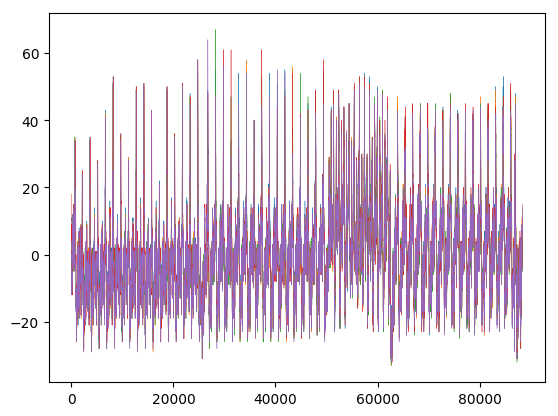

5-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0b220861d0>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b22086290>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b22086350>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b22086410>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b220864d0>

In [3]:
# read and plot 3 traces with some zoom
((data,samples),eof) = readTraces(trs, 5:10);  
plot(samples[1:5,1:nrSamples]', linewidth=.3); # note the transpose; and here you can play with the zoom

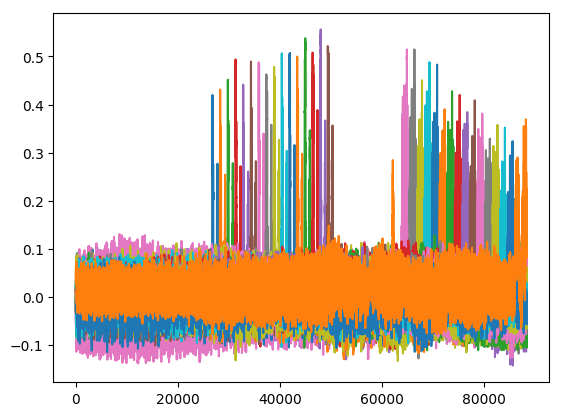

32-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0b22170290>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b220b8fd0>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b220b8f10>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b220b8e50>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b220b8d90>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b220b8cd0>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b220b8c10>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b220b8b50>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b220b8a90>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b220b89d0>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b220b8910>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b220b8850>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b220b8790>
 ⋮                                                          
 PyObject <matplotlib.lines.Line2D object at 0x7f0b22009090>
 PyObject <matplotlib.lines.Line2D object at 0x7

In [4]:
# Plot data correlations
((data,samples),eof) = readTraces(trs, 1:1000)  
plot(cor(samples[1:1000,1:nrSamples], data[:,1:32]))

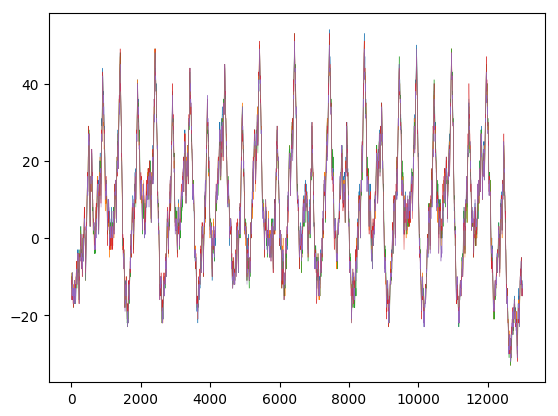

5-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0b21ee7950>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b21ee7a10>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b21ee7ad0>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b21ee7b90>
 PyObject <matplotlib.lines.Line2D object at 0x7f0b21ee7c50>

In [5]:
# Zoom in on the target area...
((data,samples),eof) = readTraces(trs, 5:10);  
plot(samples[1:5,50000:63000]', linewidth=.3); # note the transpose; and here you can play with the zoom

## Run correlation power analysis

This is the actual run section. I've had to extensively override to make things. work. We've got a custom attack, a custom leakage model, and we're using a new callback that I added into the main loop to get the data.

The leakage model is:  
HammingDistance(previousPlaintextByte ⊻ previousKeyByte, plaintextByte ⊻ keyByteGuess)  
= HammingWeight(previousPlaintextByte ⊻ previousKeyByte ⊻ plaintextByte ⊻ keyByteGuess)

That's really had for Jlsca to do. So we break it into parts.
* keyByteGuess is an argument to our `target` function
* we override data using a custom "DataPass" to be previousPlaintextByte ⊻ plaintextByte
* and we remember what key byte was selected for the last "target", using our new callback

Overall, there are 15 targets (key byte guesses), attacked times 256 phases. Each phase starts with an initial keybyte guess (0:255), and determines what full round-key correlates to that.

In [18]:
params = DpaAttack(AesTwoRoundAttack(), CPA())
params.ranksCallBack = twoRoundRankCallBack
params.dataOffset = 1
params.attack.direction = FORWARD

params.analysis.leakages = [HW()]
params.maximization = GlobalMaximization()
params.attack.rhme3 = true
params.attack.xor = true

numberOfTraces = length(trs)
numberOfTraces = 5000
range = 50000:63000

addSamplePass(trs, x -> x[range])
rankData = sca(trs, params, 1, numberOfTraces)
popSamplePass(trs)
key = getKey(params,rankData)


Jlsca running in Julia version: 0.6.2, 1 processes/1 workers/1 threads per worker

DPA parameters
attack:       AES two-round attack
mode:       CIPHER
key length: KL128
direction:  FORWARD
known key:  UInt8[]
analysis:     CPA
leakages:     HW
maximization: global max
data at:      1

phase: 1 / 1, #targets 16

Attacking columns 1:13001 out of 13001 columns
CPA on samples shape (5000, 13001) (range 1:13001) and data shape (5000,)
Results @ 5000 rows, 13001 cols (5000 rows, 13001 cols, consumed)
target: 1, phase: 1, #candidates 256, "Two-round target: (Pᵢ₋₁ ⊻ Kᵢ₋₁) ⊻ (Pᵢ ⊻ Kᵢ)"
rank:   1, candidate: 0xc0, peak: 0.134265 @ 921
rank:   2, candidate: 0xd0, peak: 0.113201 @ 917
rank:   3, candidate: 0x80, peak: 0.108265 @ 922
rank:   4, candidate: 0xc2, peak: 0.104939 @ 921
rank:   5, candidate: 0x40, peak: 0.104858 @ 918
recovered key material: c0
CPA on samples shape (5000, 13001) (range 1:13001) and data shape (5000,)
Results @ 5000 rows, 13001 cols (5000 rows, 13001 cols, consumed)
ta

16-element Array{UInt8,1}:
 0xc0
 0x8c
 0x50
 0xd8
 0x76
 0x68
 0x50
 0xd9
 0x6b
 0x2b
 0x01
 0xb3
 0x32
 0xd9
 0x5c
 0xe7

In [19]:
# If we can trust the result of the first keybyte, and we set xor=true, the whole key should have fallen out
w = KeyExpansion(key, 10, 4)
if Cipher(trs[1][1][1:16], w) == trs[1][1][17:32]
    print("Successful decrypt with key: ",bytes2hex(key),"\n")
else
    print("Key: ",bytes2hex(key)," does not match the data\n")
end

Successful decrypt with key: c08c50d8766850d96b2b01b332d95ce7


In [20]:
# If we can't trust the first keybyte, brute force it (with xor=false)
for firstByte in 0:255
    shifted = reshape(Aes.ShiftRows(reshape(key[1:16],(4,4))), 16)
    accumulator = Array{UInt8, 1}(16)
    accumulator[1] = firstByte
    for b in 2:16
        accumulator[b] = accumulator[b-1] ⊻ shifted[b]
    end
    testkey = reshape(Aes.InvShiftRows(reshape(accumulator[1:16],(4,4))), 16) 
    
    w = KeyExpansion(testkey, 10, 4)
    if Cipher(trs[1][1][1:16], w) == trs[1][1][17:32]
        print("\nSuccessful decrypt with key: ",bytes2hex(testkey),"\n")
    else
        print(".")
    end
end

................................................................................................................................................................................................................................................................